In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os
plt.style.use('seaborn')

In [2]:
# Data organized as:
# particleID / parentID / pType/ eDep (eV) / materialName / currKE (eV)

In [3]:
# Creates a "particle tree" which is a dictionary containing
# { event0 : {ptcls} , event1 : {ptcls} , ... }
# "ptcls" contains:
# { ptclID : { "allEvents" : [] , "children" : {ptcls} } }
# where "allEvents" is every event performed by the particle with ID == ptclID
# and "children" recursively stores "ptcls" structures for each child

def buildPtclTree(filePath):
    ptclTree = {}
    
    data = np.array(pd.read_csv(filePath))
    
    IDtoRow = {}
    for row in data:
        IDtoRow[row[0]] = row

    for row in data:
        skipRow = False
        
        # Stack of parents
        IDStack = []
        ID = row[0]
        while "-0" not in ID:
            IDStack.append(ID)
            if ID not in IDtoRow:
                skipRow = True
                break
            ID = IDtoRow[ID][1]
            
        if skipRow :
            continue

        ID = 0
        currTree = ptclTree
        while True:
            ID = IDStack.pop()
            if ID not in currTree:
                currTree[ID] = {"allEvents" : [] , "children" : {} , "totalEDep" : -1}

            if len(IDStack) == 0:
                currTree = currTree[ID]
                break

            currTree = currTree[ID]["children"]

        currTree["allEvents"].append(row)
        
    return ptclTree



In [4]:
# Takes in a "ptcl" and a material name, and finds the total energy deposited 
# by this particle, and all of its children, into that material

def netEDep(ptclInTree, materialName):
    eDep = 0
    for event in ptclInTree["allEvents"]:
        if event[2] in "proton" and event[4] in materialName:
            eDep += event[3]
    for child in ptclInTree["children"].values():
        eDep += netEDep(child, materialName)
    ptclInTree["totalEDep"] = eDep
    return eDep

# Takes in a "ptcl" and a particle type, and if this particle or any of its
# children have that type

def hasNoChildrenOfType(ptclInTree, ptclType):
    hasChild = True
    
    if ptclInTree["allEvents"][0][2] in ptclType:
        return False
    
    for child in ptclInTree["children"].values():
        hasChild = hasChild and hasNoChildrenOfType(child, ptclType)
    
    return hasChild

# Prints a particle

def printPtcl(ptcl, indent = ">"):
    print("\n", indent , "Particle : " , ptcl["allEvents"][0][2] , " Energy : " , (ptcl["allEvents"][0][3] + ptcl["allEvents"][0][5]) / 1e3 , " keV ")
    for child in ptcl["children"].values():
        printPtcl(child, "---" + indent)

In [496]:
# Parameters to Read
particle = "neutron"
energy = "2.45"
unit = "MeV"

try:
    os.mkdir("Edep/"+particle+energy+unit)
except:
    pass

ptclTree = buildPtclTree("../EJ309-build/data/" + particle + "_" + energy + "_" + unit + ".csv")

In [497]:
IDtoEdep = {}

for ptclID in ptclTree:
    eDep = netEDep(ptclTree[ptclID], "ej309")
    if eDep > 0.0:
        IDtoEdep[ptclID] = eDep


In [502]:
Edepo = np.array(list(IDtoEdep.values()))

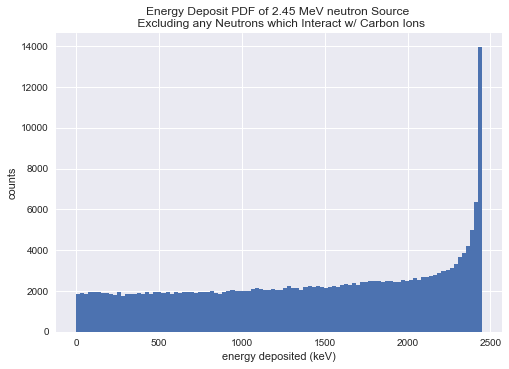

In [504]:
plt.hist(Edepo / 1000.0, bins = 100, range = (0, float(energy) * 1000.0))
plt.xlabel("energy deposited (keV)")
plt.ylabel("counts")
plt.title("Energy Deposit PDF of " 
         + energy + " " + unit + " " + particle + " Source"  
         + " \n Excluding any Neutrons which Interact w/ Carbon Ions")

plt.savefig("Edep/"+particle+energy+unit+"/Edep.eps")

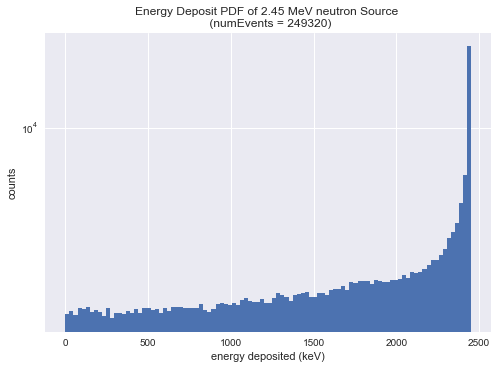

In [505]:
plt.hist(Edepo / 1000.0, bins = 100)
plt.xlabel("energy deposited (keV)")
plt.ylabel("counts")
plt.title("Energy Deposit PDF of " 
              + energy + " " + unit + " " + particle 
              + " Source \n (numEvents = " + str(len(Edepo)) + ")")
plt.yscale("log")
plt.savefig("Edep/"+particle+energy+unit+"/Edep_FULLRANGE.eps")

In [506]:
import matplotlib
# x axis num of scatters, y axis eDep

IDtoNumScatters = {}
for ptclID in ptclTree:
    numScatters = len(ptclTree[ptclID]["children"])
    if numScatters > 0:
        IDtoNumScatters[ptclID] = numScatters

x = []
y = []

event = 0
for ID in IDtoNumScatters:
    if ID in IDtoEdep.keys():
        x.append(IDtoNumScatters[ID])
        y.append(IDtoEdep[ID] / 1000.0)



In [507]:
print(np.mean(list(IDtoNumScatters.values())))

2.2621074846268603


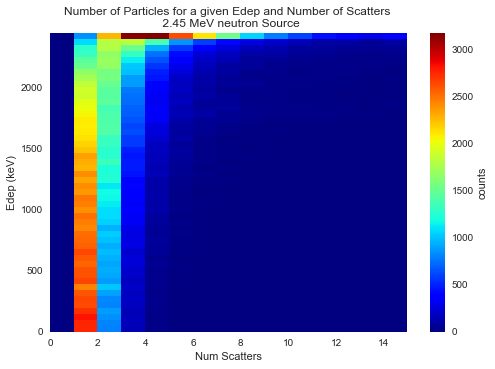

In [508]:
plt.hist2d(x, y, bins = (15, 50), range = ( (0, 15) , (0, float(energy) * 1000.0) ), cmap=plt.cm.jet)
plt.xlabel("Num Scatters")
plt.ylabel("Edep (keV)")
plt.title("Number of Particles for a given Edep and Number of Scatters \n "
          + energy + " " + unit + " " + particle + " Source")
cbar = plt.colorbar()
cbar.set_label("counts")
plt.savefig("Edep/"+particle+energy+unit+"/scatters.eps")

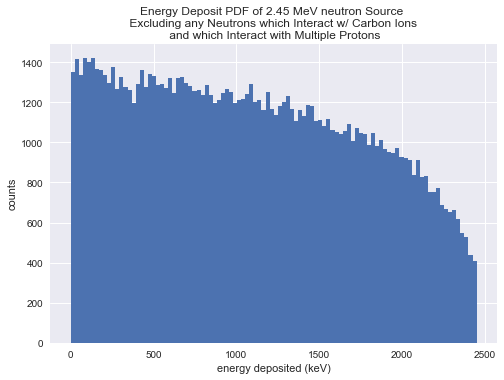

In [509]:
OneSIDtoEdep = {}

for ptclID in IDtoNumScatters:
    if IDtoNumScatters[ptclID] == 1:
        eDep = netEDep(ptclTree[ptclID], "ej309")
        if eDep > 0.0:
            OneSIDtoEdep[ptclID] = eDep

plt.hist(np.array(list(OneSIDtoEdep.values())) / 1000.0, bins=100)
plt.xlabel("energy deposited (keV)")
plt.ylabel("counts")
plt.title("Energy Deposit PDF of " 
         + energy + " " + unit + " " + particle + " Source"  
         + " \n Excluding any Neutrons which Interact w/ Carbon Ions"
         + " \n and which Interact with Multiple Protons")
plt.savefig("Edep/"+particle+energy+unit+"/Edep_ONESCATTER.eps")

In [437]:
def findClosestEvent(ptcl, time):
    return min( ptcl["allEvents"] , key = lambda x : np.abs(x[6] - time) ) 

Text(0.5, 0, 'ratio ( Ep1 / En0 )')

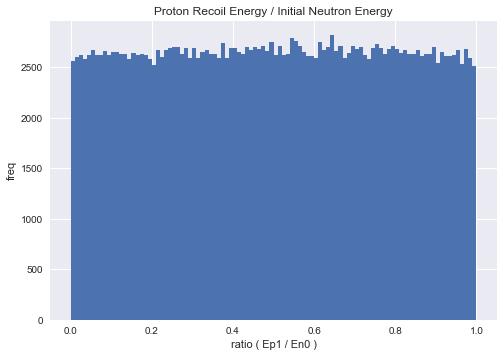

In [480]:
# Finds the ratio of energy transfered from the neutron
# to the proton for a given collision 

protonTransfer = {}

for ptcl in ptclTree.values():
    
    for child in ptcl["children"].values():
        
        if child["allEvents"][0][2] not in "proton":
            continue
            
        event = findClosestEvent(child, -1e6)
        ID = event[0]
        protonE = event[5]
        parent = event[1]
        
        time = event[6]
        neutronE = findClosestEvent(ptcl, time)[5]
        protonTransfer[ID] = protonE / ( neutronE + protonE )
        
plt.hist(protonTransfer.values(), bins = 100)
plt.title("Proton Recoil Energy / Initial Neutron Energy")
plt.ylabel("freq")
plt.xlabel("ratio ( Ep1 / En0 )")
    